# Attention

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random

dataset_ingredienti = [
    (["uovo", "farina", "zucchero"], "burro"),
    (["uovo", "latte", "vaniglia"], "zucchero"),
    (["latte", "zucchero", "cioccolato"], "burro"),
    (["farina", "zucchero", "lievito"], "uovo"),
    (["uovo", "farina", "latte"], "zucchero"),
    (["cioccolato", "burro", "zucchero"], "latte"),
    (["uovo", "farina", "burro"], "lievito"),
    (["latte", "farina", "zucchero"], "vaniglia"),
    (["pasta", "pomodoro", "aglio"], "olio"),
    (["riso", "cipolla", "brodo"], "burro"),
    (["patate", "olio", "rosmarino"], "sale"),
    (["pane", "prosciutto", "formaggio"], "burro"),
    (["uovo", "formaggio", "pepe"], "pancetta"),  # carbonara
    (["pasta", "tonno", "pomodoro"], "cipolla"),
    (["carne", "olio", "sale"], "pepe"),
    (["riso", "zafferano", "burro"], "parmigiano"),
    (["pasta", "burro", "formaggio"], "latte"),
    (["zucchine", "olio", "cipolla"], "sale"),
]

ingredienti_vocab = {"<PAD>": 0}

counter = 1
for ingredients, target in dataset_ingredienti:
    for i in ingredients + [target]:
        if i in ingredienti_vocab.keys():
            pass
        else:
            ingredienti_vocab[i] = counter 
            counter += 1

id2word = {v: k for k, v in ingredienti_vocab.items()}
vocab_size = len(ingredienti_vocab)
PAD_IDX = ingredienti_vocab["<PAD>"]

In [2]:
ingredienti_vocab

{'<PAD>': 0,
 'uovo': 1,
 'farina': 2,
 'zucchero': 3,
 'burro': 4,
 'latte': 5,
 'vaniglia': 6,
 'cioccolato': 7,
 'lievito': 8,
 'pasta': 9,
 'pomodoro': 10,
 'aglio': 11,
 'olio': 12,
 'riso': 13,
 'cipolla': 14,
 'brodo': 15,
 'patate': 16,
 'rosmarino': 17,
 'sale': 18,
 'pane': 19,
 'prosciutto': 20,
 'formaggio': 21,
 'pepe': 22,
 'pancetta': 23,
 'tonno': 24,
 'carne': 25,
 'zafferano': 26,
 'parmigiano': 27,
 'zucchine': 28}

## Creazione del dataset

In [3]:
class RicetteDataset(Dataset):
    def __init__(self, ricette_raw, seq_len):
        self.seq_len = seq_len
        self.ricette = []
        for ricetta in ricette_raw:
            # Usiamo gli ultimi ingredienti per predire il prossimo
            if len(ricetta) < 2:
                continue
            input_seq = ricetta[:-1]
            target = ricetta[-1]
            # Pad a sinistra
            padded = [PAD_IDX] * (seq_len - len(input_seq)) + input_seq
            self.ricette.append((padded, target))

    def __len__(self):
        return len(self.ricette)

    def __getitem__(self, idx):
        x, y = self.ricette[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

def pre_process(ricette):
    data, target = [], []
    for ricetta in ricette:
        ingredienti, target = ricetta[0], ricetta[-1]
        data.append([ingredienti_vocab[i] for i in ingredienti] + [ingredienti_vocab[target]])
    return data

In [4]:
ricette_raw = pre_process(dataset_ingredienti)

dataset = RicetteDataset(ricette_raw, seq_len=4)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [5]:
for batch in dataloader:
    print(batch, "\n")
    print(f"Ingredienti: {[id2word[int(x)] for x in batch[0][0]]}")
    print(f"Target: {id2word[int(batch[1][0])]}\n")
    print(f"Ingredienti: {[id2word[int(x)] for x in batch[0][1]]}")
    print(f"Target: {id2word[int(batch[1][1])]}\n")
    break 

[tensor([[ 0, 25, 12, 18],
        [ 0,  2,  3,  8]]), tensor([22,  1])] 

Ingredienti: ['<PAD>', 'carne', 'olio', 'sale']
Target: pepe

Ingredienti: ['<PAD>', 'farina', 'zucchero', 'lievito']
Target: uovo



## Training

In [6]:
from nlp.transformer import SimpleIngredientTransformer

In [7]:
model = SimpleIngredientTransformer(vocab_size=vocab_size, d_model=32, pad_idx=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [8]:
history = []
for epoch in range(10):
    for x_batch, y_batch in dataloader:
        logits, attn = model(x_batch)
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        history.append(loss.item())

In [9]:
import matplotlib.pyplot as plt

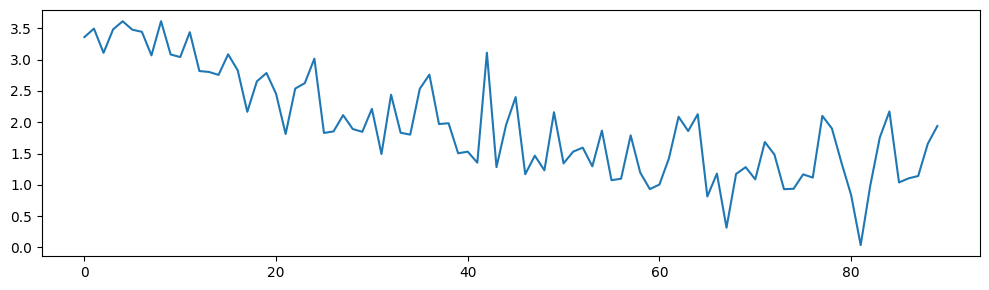

In [10]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(history)
plt.tight_layout()
plt.show()

## Predizione

In [16]:
seq_len = 4
input_ingredienti = ["vaniglia", "zucchero", "burro"]
input_ids = [ingredienti_vocab[ing] for ing in input_ingredienti]
padding = [PAD_IDX] * (seq_len - len(input_ids))
input_padded = padding + input_ids
input_tensor = torch.tensor([input_padded], dtype=torch.long) 

model.eval()
with torch.no_grad():
    logits, attn = model(input_tensor)
    predicted_idx = torch.argmax(logits, dim=-1).item()
    predicted_ingrediente = id2word[predicted_idx]

print(f"Input: {input_ingredienti}")
print(f"Ingrediente previsto: {predicted_ingrediente}")

Input: ['vaniglia', 'zucchero', 'burro']
Ingrediente previsto: uovo


## Logits

In [17]:
import pandas as pd

In [18]:
pd.Series(logits[0], index=ingredienti_vocab.keys()).sort_values(ascending=False).head(10)

uovo        5.030844
burro       4.798534
cipolla     3.018476
pepe        1.435055
lievito    -0.313913
zucchero   -0.615332
olio       -0.804847
pancetta   -0.976947
latte      -0.982219
sale       -1.077566
dtype: float32

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

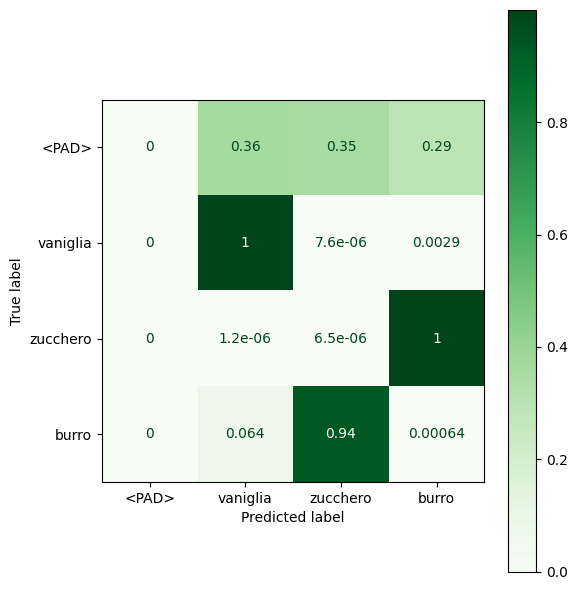

In [20]:
A = attn[0][0].numpy()

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=A, display_labels=[id2word[x] for x in input_padded])
disp.plot(ax=ax, cmap='Greens')
plt.tight_layout()
plt.show()